## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/'
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for results and load aligned images from Matlab GUI

In [3]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        #if ("samecellonly" in str(filelist[i]))==False:
            if ("output_classification" in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                  "sted spot aligned filename":[],
                "vglut spot aligned":[],
                   "vglut spot aligned filename":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[],
                 "dio intensity sted, bg subtracted":[]}
                  
num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned filename"].append(file2read)
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["vglut spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)
    
    synapses_results["dio intensity sted, bg subtracted"].append(np.nan)
    
clear_output() 

## Tot. no. synapses read

In [4]:
len(synapses_results["spots classification filename"])

804

## Make dictionary for individual synapse (spot) images

In [5]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["dio spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["dio intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make DF

In [6]:
df=pd.DataFrame(synapses_results)


df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan

df["sted spot aligned under dio"]=df["sted spot aligned"]
df["ecm intensity sted, bg subtracted under dio"]=df["ecm intensity sted, bg subtracted"]
df["vglut spot aligned under dio"]=df["vglut spot aligned"]
df["vglut intensity sted, bg subtracted under dio"]=df["vglut intensity sted, bg subtracted"]

df["mean ecm intensity sted under dio"]=np.nan
df["mean vglut intensity sted under dio"]=np.nan
df["mean ecm intensity sted, bg subtracted under dio"]=np.nan
df["mean vglut intensity sted, bg subtracted under dio"]=np.nan

df["dio size"]=np.nan

for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()
    
    diomask=df["dio intensity sted, bg subtracted"][i]>0
    
    df["dio size"][i]=np.nansum(diomask)
    
    image=df["sted spot aligned under dio"][i]
    image[~diomask]=0
    df["sted spot aligned under dio"][i]=image 
    
    image=df["ecm intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["ecm intensity sted, bg subtracted under dio"][i]=image    
    
    image=df["vglut spot aligned under dio"][i]
    image[~diomask]=0
    df["vglut spot aligned under dio"][i]=image    
    
    image=df["vglut intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["vglut intensity sted, bg subtracted under dio"][i]=image
    
    df["mean ecm intensity sted under dio"][i]=df["sted spot aligned under dio"][i].mean()
    df["mean vglut intensity sted under dio"][i]=df["vglut spot aligned under dio"][i].mean()
    df["mean ecm intensity sted, bg subtracted under dio"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted under dio"][i]=df["vglut intensity sted, bg subtracted under dio"][i].mean()

df2=deepcopy(df)
df2=df2.reset_index()

df2['Protein']='None'
df2.loc[df2['spots classification filename'].str.contains('TGN'), 'Protein'] = 'TGN38'
df2.loc[df2['spots classification filename'].str.contains('alreticulin'), 'Protein'] = 'Calreticulin'
df2.loc[df2["spots classification filename"].str.contains('Synaptopodin'), 'Protein'] = 'Synaptopodin'
df2.loc[df2["spots classification filename"].str.contains('ERGIC'), 'Protein'] = 'ERGIC'

df2['Exp']='None'
df2.loc[df2['spots classification filename'].str.contains('N2_'), 'Exp'] = 'N2'
df2.loc[df2['spots classification filename'].str.contains('N1_'), 'Exp'] = 'N1'
df2.loc[df2['spots classification filename'].str.contains('N0_'), 'Exp'] = 'N0'
df2.loc[df2['spots classification filename'].str.contains('N3_'), 'Exp'] = 'N3'
df2.loc[df2['spots classification filename'].str.contains('N4_'), 'Exp'] = 'N4'

df2.loc[df2['spots classification filename'].str.contains('Other Data'), 'Exp'] = 'Other Data'
df2.loc[df2['spots classification filename'].str.contains('BIN'), 'Exp'] = 'BIN'

df2["Classification"]="none"
df2.loc[df2["classification"]==1.0,"Classification"]="Mushroom"
df2.loc[df2["classification"]==2.0,"Classification"]="Flat"
df2.loc[df2["classification"]==3.0,"Classification"]="Bouton"

dfbackup=deepcopy(df2)

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning

## Show random image

Text(0.5, 1.0, 'dio around synapse spot')

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


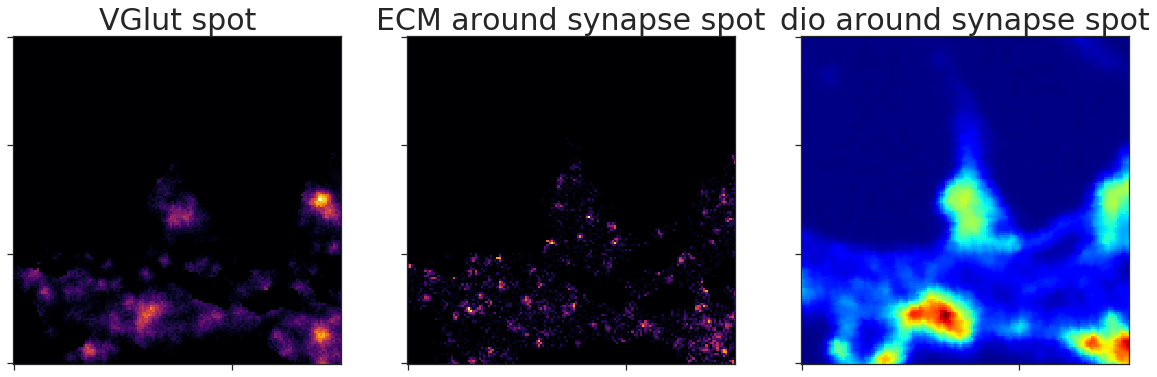

In [10]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["vglut intensity sted, bg subtracted"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df["ecm intensity sted, bg subtracted"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

## Remove outliers

In [11]:
vari="mean ecm intensity sted, bg subtracted under dio"
df2=df2[df2[vari]<df2[vari].quantile(.99)]

In [12]:
protein="ERGIC"

## ttests

In [13]:
vari='mean ecm intensity sted, bg subtracted under dio'

df2protein=df2[df2["Protein"]==protein]

mush=df2protein[df2protein["Classification"]=="Mushroom"][vari].dropna().values
flat=df2protein[df2protein["Classification"]=="Flat"][vari].dropna().values

[stat,pval_1]=stats.ttest_ind(mush, flat)

print(mush.mean())
print(flat.mean())
print(pval_1)


0.3428094992310027
0.3984664160715168
0.0048109601053246435


## Plots

## Plot unblocked

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


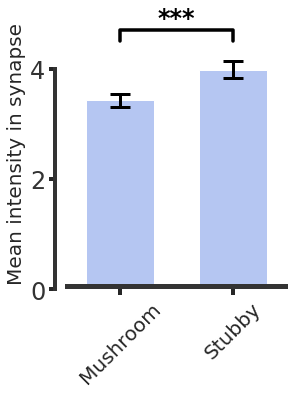

In [14]:

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

df2plot=df2protein

fig=plt.figure(figsize=(4,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=["Mushroom","Flat"]

g=sns.barplot(data=df2plot,y=vari,x="Classification"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Classification"]==condtype][vari].mean() for condtype in order],
             yerr=[df2plot[df2plot["Classification"]==condtype][vari].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
#plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('Mean intensity in synapse',size=20)
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby'],
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


x1, x2 = 0,1
y= .45
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


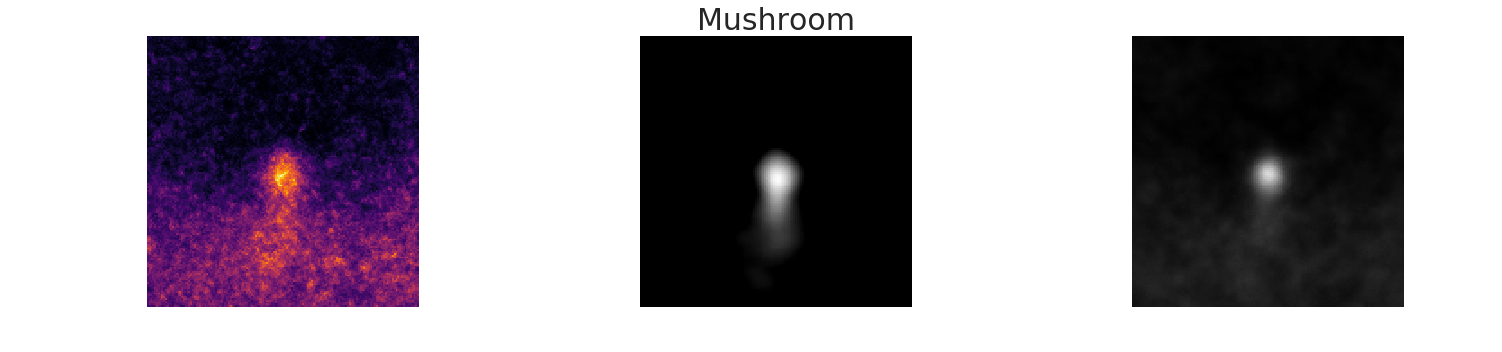

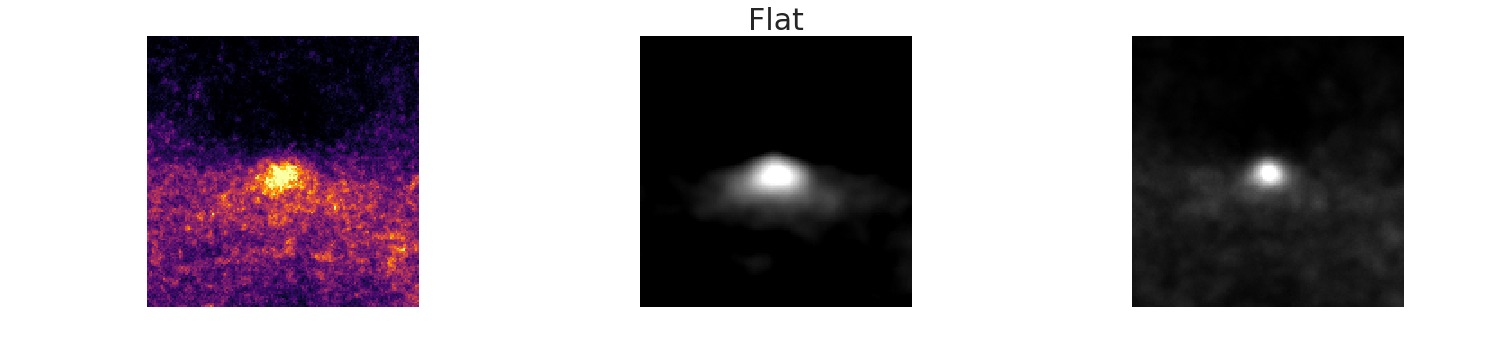

In [15]:
var="ecm intensity sted, bg subtracted under dio"

homer= 'vglut intensity sted, bg subtracted under dio'

for classi in ["Mushroom","Flat"]:
    df2protein_class=df2protein[df2protein["Classification"]==classi]
    fig=plt.figure(figsize=(25,5))
    plt.title(classi)
    plt.axis('off')
    #plt.title(str(i))
    fig.add_subplot(131)
    plt.imshow(df2protein_class[var].mean()
               ,cmap='inferno',
               vmin=2*df2protein[var].mean().min(),
               vmax=0.9*np.max(df2protein[var].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class[var].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_sted.tiff')

    fig.add_subplot(132)
    plt.imshow(df2protein_class["dio spot aligned"].mean()
               ,cmap='gray',
               vmin=1.0009*np.min(df2protein["dio spot aligned"].mean()),
               vmax=.9999*np.max(df2protein["dio spot aligned"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class["dio spot aligned"].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')

    fig.add_subplot(133)
    plt.imshow(df2protein_class[homer].mean()
               ,cmap='gray',
               vmin=1.0009*np.min(df2protein[homer].mean()),
               vmax=.9999*np.max(df2protein[homer].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class["dio spot aligned"].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')

## Check correlation to size - all

In [16]:
##sort df according to synapse intensity
df3=deepcopy(df2protein)
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

## plot corr2size new epitopes

In [17]:
synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

<Figure size 432x288 with 0 Axes>

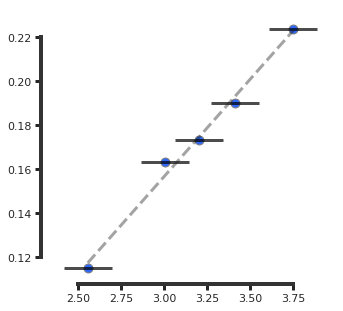

In [132]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

In [110]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

0.192841084044657
0.45940354035865266


## corr2size mushrooms

In [133]:
df2["Classification"].unique()

array(['Mushroom', 'Flat'], dtype=object)

0.9648483937956017
0.0028271563052777184


<Figure size 432x288 with 0 Axes>

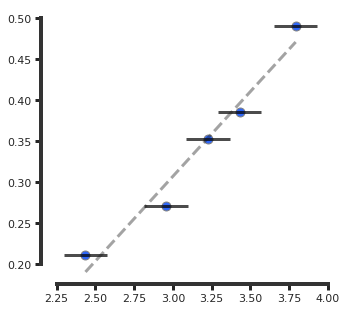

In [159]:
##sort df according to synapse intensity
df3=deepcopy(df2protein[df2protein["Classification"]=="Mushroom"])
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

## corr2size flats

0.9410128234107884
0.006191437635453517


<Figure size 432x288 with 0 Axes>

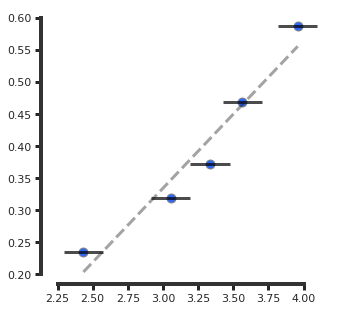

In [160]:
##sort df according to synapse intensity
df3=deepcopy(df2protein[df2protein["Classification"]=="Flat"])
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

## Distribution analyses

- Read icy binary tif files
- for each spot: 
    - calculate mean distance between nearest neighbours
    - calculate mean distance between nearest neighbours weighted by intensity
    - calculate mean distance from nearest homer spot
    - calculate mean distance from nearest homer spot weighted by intensity

In [19]:
df2=df2.reset_index(drop=True)

1 out of 795


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 out of 795
3 out of 795
4 out of 795
5 out of 795
6 out of 795
7 out of 795
8 out of 795
9 out of 795
10 out of 795
11 out of 795
12 out of 795
13 out of 795
14 out of 795
15 out of 795
16 out of 795
17 out of 795
18 out of 795
19 out of 795
20 out of 795
21 out of 795
22 out of 795
23 out of 795
24 out of 795
25 out of 795
26 out of 795
27 out of 795
28 out of 795
29 out of 795
30 out of 795
31 out of 795
32 out of 795
33 out of 795
34 out of 795
35 out of 795
36 out of 795
37 out of 795
38 out of 795
39 out of 795
40 out of 795
41 out of 795
42 out of 795
43 out of 795
44 out of 795
45 out of 795
46 out of 795
47 out of 795
48 out of 795
49 out of 795
50 out of 795
51 out of 795
52 out of 795
53 out of 795
54 out of 795
55 out of 795
56 out of 795
57 out of 795
58 out of 795
59 out of 795
60 out of 795
61 out of 795
62 out of 795
63 out of 795
64 out of 795
65 out of 795
66 out of 795
67 out of 795
68 out of 795
69 out of 795
70 out of 795
71 out of 795
72 out of 795
73 out of 795


556 out of 795
557 out of 795
558 out of 795
559 out of 795
560 out of 795
561 out of 795
562 out of 795
563 out of 795
564 out of 795
565 out of 795
566 out of 795
567 out of 795
568 out of 795
569 out of 795
570 out of 795
571 out of 795
572 out of 795
573 out of 795
574 out of 795
575 out of 795
576 out of 795
577 out of 795
578 out of 795
579 out of 795
580 out of 795
581 out of 795
582 out of 795
583 out of 795
584 out of 795
585 out of 795
586 out of 795
587 out of 795
588 out of 795
589 out of 795
590 out of 795
591 out of 795
592 out of 795
593 out of 795
594 out of 795
595 out of 795
596 out of 795
597 out of 795
598 out of 795
599 out of 795
600 out of 795
601 out of 795
602 out of 795
603 out of 795
604 out of 795
605 out of 795
606 out of 795
607 out of 795
608 out of 795
609 out of 795
610 out of 795
611 out of 795
612 out of 795
613 out of 795
614 out of 795
615 out of 795
616 out of 795
617 out of 795
618 out of 795
619 out of 795
620 out of 795
621 out of 795
622 out of

In [75]:
import scipy
from skimage.measure import label, regionprops
from PIL import Image



df2["mean dist to nearest neighbour - sted"]=np.nan
df2["mean dist sted to nearest homer"]=np.nan

for spot in range(0,len(df2)):
    print(str(spot+1)+' out of ' + str(len(df2)))
    
    sted_image=df2["sted spot aligned"][spot]
    sted_icy_mask_name=df2["sted spot aligned filename"][spot]+'_sted_icy_wavelet_binary.tif'
    sted_icy_mask=np.asarray(Image.open(sted_icy_mask_name))>0
    
    homer_image=df2["vglut spot aligned"][spot]
    homer_icy_mask_name=df2["vglut spot aligned filename"][spot]+'_homer_icy_wavelet_binary.tif'
    homer_icy_mask=np.asarray(Image.open(homer_icy_mask_name))>0
    
    #label masks
    labeled_sted=label(sted_icy_mask)
    labeled_homer=label(homer_icy_mask)
    #props
    regionprops_sted=regionprops(labeled_sted)
    regionprops_homer=regionprops(labeled_homer)
    #get centroids
    centroids_sted=[]
    centroid_homer=[]
    for i in range(0,len(regionprops_sted)):
        centroids_sted.append(regionprops_sted[i]['centroid'])
    for i in range(0,len(regionprops_homer)):
        centroid_homer.append(regionprops_homer[i]['centroid'])  
    
    df2["mean dist sted to nearest homer"][spot]=scipy.spatial.distance.cdist(np.asarray(centroids_sted),centroid_homer,'euclidean').mean()
    
    df2["mean dist to nearest neighbour - sted"][spot]=scipy.spatial.distance.cdist(np.asarray(centroids_sted),centroids_sted,'euclidean').mean()

1 out of 795


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 out of 795
3 out of 795
4 out of 795
5 out of 795
6 out of 795
7 out of 795
8 out of 795
9 out of 795
10 out of 795
11 out of 795
12 out of 795
13 out of 795
14 out of 795
15 out of 795
16 out of 795
17 out of 795
18 out of 795
19 out of 795
20 out of 795
21 out of 795
22 out of 795
23 out of 795
24 out of 795
25 out of 795
26 out of 795
27 out of 795
28 out of 795
29 out of 795
30 out of 795
31 out of 795
32 out of 795
33 out of 795
34 out of 795
35 out of 795
36 out of 795
37 out of 795
38 out of 795
39 out of 795
40 out of 795
41 out of 795
42 out of 795
43 out of 795
44 out of 795
45 out of 795
46 out of 795
47 out of 795
48 out of 795
49 out of 795
50 out of 795
51 out of 795
52 out of 795
53 out of 795
54 out of 795
55 out of 795
56 out of 795
57 out of 795
58 out of 795
59 out of 795
60 out of 795
61 out of 795
62 out of 795
63 out of 795
64 out of 795
65 out of 795
66 out of 795
67 out of 795
68 out of 795
69 out of 795
70 out of 795
71 out of 795
72 out of 795
73 out of 795


556 out of 795
557 out of 795
558 out of 795
559 out of 795
560 out of 795
561 out of 795
562 out of 795
563 out of 795
564 out of 795
565 out of 795
566 out of 795
567 out of 795
568 out of 795
569 out of 795
570 out of 795
571 out of 795
572 out of 795
573 out of 795
574 out of 795
575 out of 795
576 out of 795
577 out of 795
578 out of 795
579 out of 795
580 out of 795
581 out of 795
582 out of 795
583 out of 795
584 out of 795
585 out of 795
586 out of 795
587 out of 795
588 out of 795
589 out of 795
590 out of 795
591 out of 795
592 out of 795
593 out of 795
594 out of 795
595 out of 795
596 out of 795
597 out of 795
598 out of 795
599 out of 795
600 out of 795
601 out of 795
602 out of 795
603 out of 795
604 out of 795
605 out of 795
606 out of 795
607 out of 795
608 out of 795
609 out of 795
610 out of 795
611 out of 795
612 out of 795
613 out of 795
614 out of 795
615 out of 795
616 out of 795
617 out of 795
618 out of 795
619 out of 795
620 out of 795
621 out of 795
622 out of

In [72]:
df2["mean dist to nearest neighbour - sted"].mean()

0.0

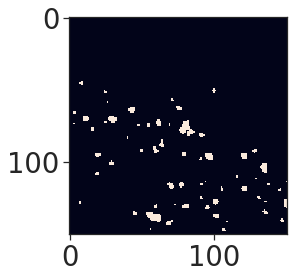

In [57]:
plt.imshow(homer_icy_mask)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

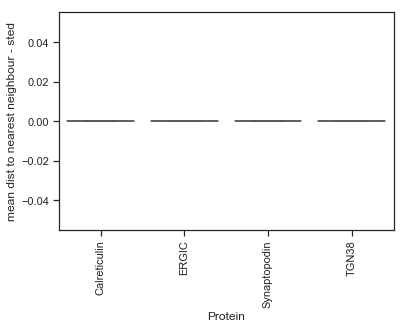

In [73]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
sns.boxplot(x="Protein",y="mean dist to nearest neighbour - sted",data=df2)
plt.xticks(rotation=90)


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

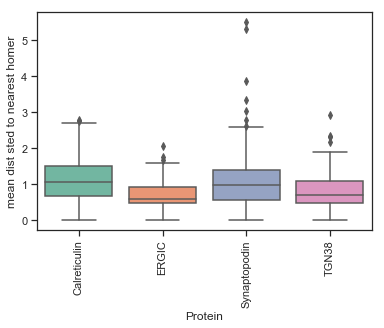

In [74]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
sns.boxplot(x="Protein",y="mean dist sted to nearest homer",data=df2)
plt.xticks(rotation=90)

